# W281 Final Project: Intel Image Classification Model #

### Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import gc

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout,BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage import io, color

### Data Load

In [3]:
def load_data(datasets):
    
    output = []

    for dataset in datasets:
        images, labels = [], []
        print(f"Loading {dataset}...")
        i = 0
        for folder in os.listdir(dataset):
            label = i # Converting word labels to int (i.e. buildings = 0)
            i = i+1
            folder_path = os.path.join(dataset, folder)

            for file in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
                img_path = os.path.join(folder_path, file)

                image = Image.open(img_path).resize((150, 150))
                images.append(image)
                labels.append(label)
                
        images = np.stack(images)
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))
        
    return output

In [4]:
datasets = [r"C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_train", 
        r"C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_test"]

train_path, test_path = datasets

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data(datasets)

Loading C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_train...


Processing buildings:   0%|          | 0/2191 [00:00<?, ?it/s]

Processing street: 100%|██████████| 2382/2382 [01:13<00:00, 32.54it/s]


Loading C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_test...


Processing Street: 100%|██████████| 501/501 [00:16<00:00, 30.70it/s]


In [6]:
# Reshape images into 2D array (flatten each image)
# Flatten the data for Random Forest & SVM
train_images_flat = train_images.reshape(len(train_images), -1)
test_images_flat = test_images.reshape(len(test_images), -1)

### Clean Data

In [7]:
# Normalization
train_images = train_images / 255.0 
test_images = test_images / 255.0

### Feature Extraction

#### HSV Feature Extraction

In [8]:
def create_hsv_feature_vectors(images, bins=32):
    all_hsv_features = []
    
    for img in tqdm(images):
        # Convert RGB to HSV
        hsv_img = color.rgb2hsv(img)
        
        hsv_features = hsv_img.reshape(-1)  # Flattens to 1D array
        
        all_hsv_features.append(hsv_features)
    
    # Convert to numpy array
    feature_vectors = np.array(all_hsv_features)
    
    return feature_vectors

In [9]:
# Use it on your datasets
train_hsv_features = create_hsv_feature_vectors(train_images)
test_hsv_features = create_hsv_feature_vectors(test_images)

  0%|          | 0/14034 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:35<00:00, 84.01it/s] 


#### HOG Feature Extraction

In [10]:
def create_hog_feature_vectors(images):
    
    # Initialize list to store HOG features for each image
    all_hog_features = []
    
    # Process each image individually
    for img in tqdm(images):

        # Convert single image to grayscale
        gray_img = color.rgb2gray(img)
        
        # Calculate HOG features for image
        hog_features, _= hog(
            gray_img,
            orientations=9,  # default value, keeping this
            pixels_per_cell=(16, 16),  # increased from 8x8 to 16x16
            cells_per_block=(2, 2),  # keeping this the same
            block_norm='L2-Hys',
            visualize=True,
            feature_vector=True
        )
        
        all_hog_features.append(hog_features)
    
    # Convert list of features to numpy array
    feature_vectors = np.array(all_hog_features)
    
    return feature_vectors

In [11]:
# Create feature vectors for both training and test sets
train_hog_features = create_hog_feature_vectors(train_images)
test_hog_features = create_hog_feature_vectors(test_images)

100%|██████████| 3000/3000 [03:55<00:00, 12.76it/s]


In [12]:
train_hog_features = train_images.reshape(len(train_hog_features), -1)
test_hog_features = test_images.reshape(len(test_hog_features), -1)

#### PCA Dimensionality Reduction

In [13]:
# START INPUTTING FEATURE VECTORS HERE: (train_hog_features, train_hog_labels), (test_hog_features, test_hog_labels)
# Create train/validation splits
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(
    train_images_flat,
    train_labels,
    test_size=0.2,
    random_state=42
)

##### Batch Processing: Computing Mean and Variance for StandardScaler

In [14]:
# Define batch size
batch_size = 500
n_samples, n_features = X_train_ml.shape

# First pass: Compute mean and variance for StandardScaler
mean_sum = np.zeros(n_features, dtype=np.float32)
var_sum = np.zeros(n_features, dtype=np.float32)
n_total = 0

print("Computing mean and variance in batches...")
for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    
    # Update mean and variance sums
    mean_sum += np.sum(batch, axis=0)
    var_sum += np.sum(np.square(batch), axis=0)
    n_total += batch.shape[0]
    
    if i % 2000 == 0:
        print(f"Processed {i}/{n_samples} samples")

# Calculate final mean and variance
mean = mean_sum / n_total
variance = (var_sum / n_total) - np.square(mean)
scale = np.sqrt(variance)

Computing mean and variance in batches...
Processed 0/11227 samples
Processed 2000/11227 samples
Processed 4000/11227 samples
Processed 6000/11227 samples
Processed 8000/11227 samples
Processed 10000/11227 samples


In [15]:
# Initialize IPCA
print("Performing incremental PCA...")
n_components = 500
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    current_batch_size = end - i
    
    # Scale the batch manually
    batch_scaled = (batch - mean) / scale
    
    # Only try to fit if batch is large enough
    if current_batch_size >= n_components:
        ipca.partial_fit(batch_scaled)
        if i % 2000 == 0:
            print(f"Fitted PCA on {i}/{n_samples} samples")
    else:
        print(f"Skipping final incomplete batch of size {current_batch_size} (smaller than n_components={n_components})")

print("IPCA fitting complete!")

Performing incremental PCA...
Fitted PCA on 0/11227 samples
Fitted PCA on 2000/11227 samples
Fitted PCA on 4000/11227 samples
Fitted PCA on 6000/11227 samples
Fitted PCA on 8000/11227 samples
Fitted PCA on 10000/11227 samples
Skipping final incomplete batch of size 227 (smaller than n_components=500)
IPCA fitting complete!


In [16]:
# Third pass: Transform data in batches and train classifier
X_train_transformed = np.zeros((n_samples, n_components), dtype=np.float32)

print("Transforming data...")
for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    
    # Scale and transform batch
    batch_scaled = (batch - mean) / scale
    X_train_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_samples} samples")

print("Final reduced data shape:", X_train_transformed.shape)

Transforming data...
Transformed 0/11227 samples
Transformed 2000/11227 samples
Transformed 4000/11227 samples
Transformed 6000/11227 samples
Transformed 8000/11227 samples
Transformed 10000/11227 samples
Final reduced data shape: (11227, 500)


In [17]:
# Transform Validation Data
print("Transforming validation data...")
n_val_samples = X_val_ml.shape[0]
X_val_transformed = np.zeros((n_val_samples, n_components), dtype=np.float32)

for i in range(0, n_val_samples, batch_size):
    end = min(i + batch_size, n_val_samples)
    batch = X_val_ml[i:end].astype(np.float32)
    
    # Scale and transform batch using already computed mean/scale
    batch_scaled = (batch - mean) / scale
    X_val_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_val_samples} validation samples")

print("Validation data transformation complete!")
print("Validation data reduced shape:", X_val_transformed.shape)

Transforming validation data...
Transformed 0/2807 validation samples
Transformed 2000/2807 validation samples
Validation data transformation complete!
Validation data reduced shape: (2807, 500)


In [18]:
# Transform Test Data
print("Transforming test data...")
n_test_samples = test_images_flat.shape[0]
X_test_transformed = np.zeros((n_test_samples, n_components), dtype=np.float32)

for i in range(0, n_test_samples, batch_size):
    end = min(i + batch_size, n_test_samples)
    batch = test_images_flat[i:end].astype(np.float32)
    
    # Scale and transform batch using already computed mean/scale
    batch_scaled = (batch - mean) / scale
    X_test_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_test_samples} test samples")

print("Test data transformation complete!")
print("Test data reduced shape:", X_test_transformed.shape)

Transforming test data...
Transformed 0/3000 test samples
Transformed 2000/3000 test samples
Test data transformation complete!
Test data reduced shape: (3000, 500)


### Models

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)

#### Perceptron

In [16]:
from sklearn.linear_model import Perceptron

In [18]:
X_train_perc, X_val_perc, y_train_perc, y_val_perc = train_test_split(
    train_images_flat,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [19]:
# Initialize the Perceptron with the appropriate number of inputs
perceptron = Perceptron(tol=1e-3, random_state=0)

##### Original Images

In [ ]:
# Train
# 7 m 29 s
perceptron.fit(X_train_perc, y_train_perc)

Perceptron()

In [ ]:
# Validation
# 0.8 s
perceptron_pred = perceptron.predict(X_val_perc)

In [1]:
print("\nClassification Report:\n", classification_report(y_val_perc, perceptron_pred, 
                                                        target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))

NameError: name 'classification_report' is not defined

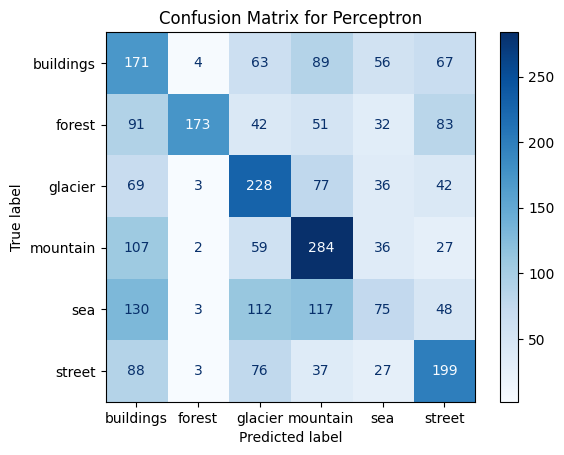

In [24]:
perceptron_cm = confusion_matrix(y_val_perc, perceptron_pred)

perceptron_disp = ConfusionMatrixDisplay(confusion_matrix = perceptron_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
perceptron_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Perceptron")
plt.show()

In [ ]:
# Predict
# 1.4 s
perceptron_pred = perceptron.predict(test_images_flat)

In [26]:
print("\nClassification Report:\n", classification_report(test_labels, perceptron_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.32      0.27       437
           1       0.92      0.37      0.53       474
           2       0.39      0.49      0.43       553
           3       0.43      0.55      0.48       525
           4       0.27      0.14      0.19       510
           5       0.44      0.49      0.46       501

    accuracy                           0.40      3000
   macro avg       0.45      0.39      0.39      3000
weighted avg       0.44      0.40      0.40      3000



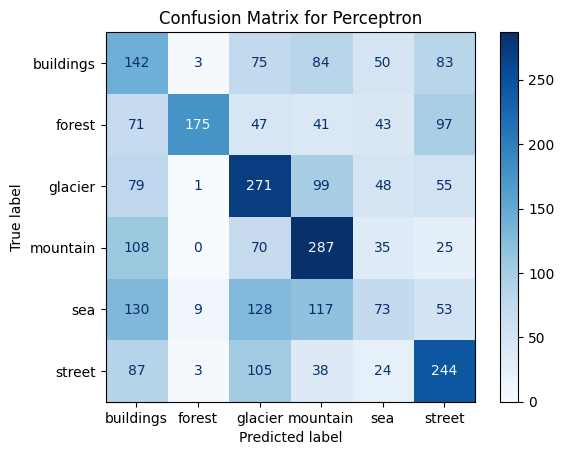

In [27]:
perceptron_cm = confusion_matrix(test_labels, perceptron_pred)

perceptron_disp = ConfusionMatrixDisplay(confusion_matrix = perceptron_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
perceptron_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Perceptron")
plt.show()

##### HSV

In [28]:
X_train_perc, X_val_perc, y_train_perc, y_val_perc = train_test_split(
    train_hsv_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
# Train
# 7 m 14.6 s
perceptron.fit(X_train_perc, y_train_perc)

Perceptron()

In [ ]:
# Validation
# 2.7 s
perceptron_pred = perceptron.predict(X_val_perc)

In [31]:
print("\nClassification Report:\n", classification_report(y_val_perc, perceptron_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.17      0.23       450
           1       0.68      0.24      0.36       472
           2       0.24      0.90      0.38       455
           3       0.41      0.28      0.33       515
           4       0.22      0.09      0.13       485
           5       0.68      0.26      0.37       430

    accuracy                           0.32      2807
   macro avg       0.43      0.32      0.30      2807
weighted avg       0.43      0.32      0.30      2807



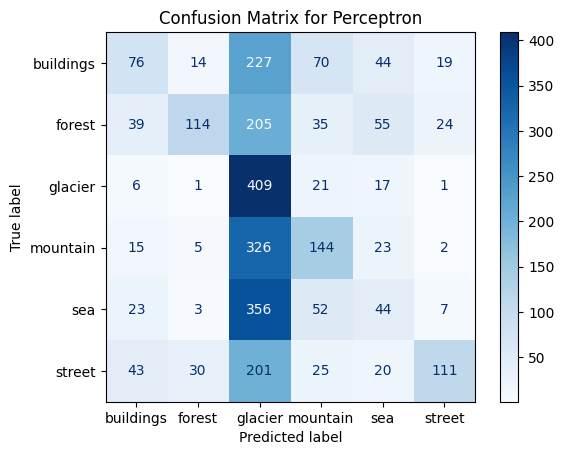

In [ ]:
perceptron_cm = confusion_matrix(y_val_perc, perceptron_pred)

perceptron_disp = ConfusionMatrixDisplay(confusion_matrix = perceptron_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
perceptron_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Perceptron")
plt.show()

In [ ]:
# Predict
# 0.5 s
perceptron_pred = perceptron.predict(test_hsv_features)

In [38]:
print("\nClassification Report:\n", classification_report(test_labels, perceptron_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.19      0.25       437
           1       0.71      0.25      0.37       474
           2       0.27      0.91      0.42       553
           3       0.44      0.28      0.34       525
           4       0.25      0.11      0.16       510
           5       0.67      0.25      0.36       501

    accuracy                           0.34      3000
   macro avg       0.45      0.33      0.32      3000
weighted avg       0.45      0.34      0.32      3000



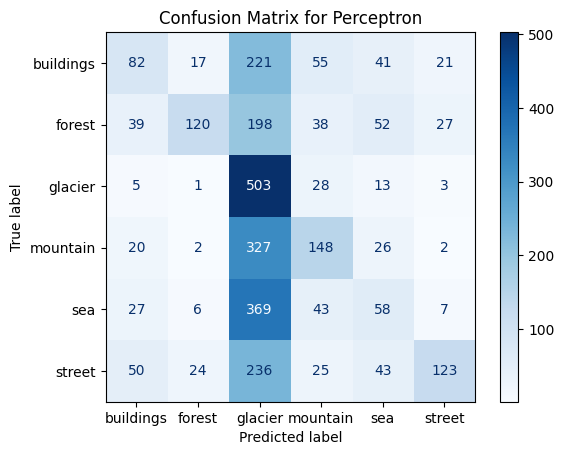

In [39]:
perceptron_cm = confusion_matrix(test_labels, perceptron_pred)

perceptron_disp = ConfusionMatrixDisplay(confusion_matrix = perceptron_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
perceptron_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Perceptron")
plt.show()

#### HOG

In [40]:
X_train_perc, X_val_perc, y_train_perc, y_val_perc = train_test_split(
    train_hog_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
# Train
# 9 m 3.2 s
perceptron.fit(X_train_perc, y_train_perc)

Perceptron()

In [ ]:
# Validation
# 3.1 s
perceptron_pred = perceptron.predict(X_val_perc)

In [44]:
print("\nClassification Report:\n", classification_report(y_val_perc, perceptron_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.27      0.28       450
           1       0.85      0.47      0.61       472
           2       0.42      0.53      0.47       455
           3       0.43      0.60      0.50       515
           4       0.26      0.21      0.23       485
           5       0.47      0.47      0.47       430

    accuracy                           0.43      2807
   macro avg       0.45      0.43      0.43      2807
weighted avg       0.45      0.43      0.43      2807



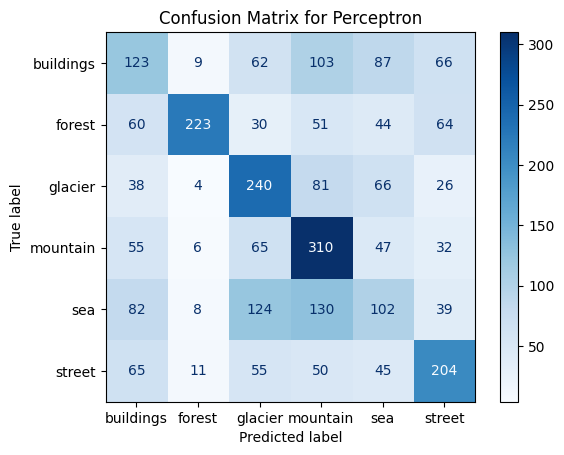

In [45]:
perceptron_cm = confusion_matrix(y_val_perc, perceptron_pred)

perceptron_disp = ConfusionMatrixDisplay(confusion_matrix = perceptron_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
perceptron_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Perceptron")
plt.show()

In [ ]:
# Test
# 4.9 s
perceptron_pred = perceptron.predict(test_hog_features)

In [47]:
print("\nClassification Report:\n", classification_report(test_labels, perceptron_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.23      0.24       437
           1       0.82      0.46      0.59       474
           2       0.44      0.53      0.48       553
           3       0.43      0.62      0.51       525
           4       0.26      0.23      0.24       510
           5       0.49      0.47      0.48       501

    accuracy                           0.43      3000
   macro avg       0.45      0.42      0.42      3000
weighted avg       0.45      0.43      0.43      3000



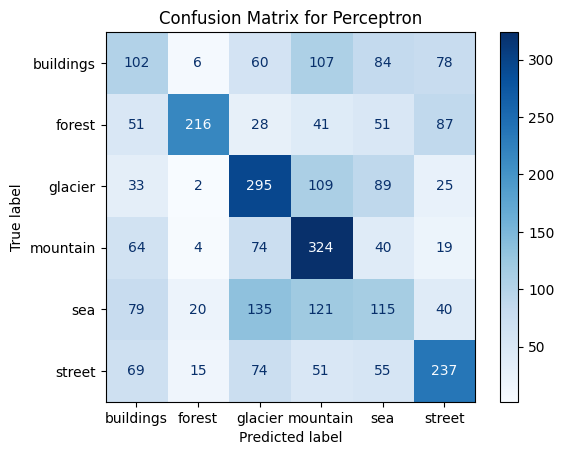

In [48]:
perceptron_cm = confusion_matrix(test_labels, perceptron_pred)

perceptron_disp = ConfusionMatrixDisplay(confusion_matrix = perceptron_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
perceptron_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Perceptron")
plt.show()

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [61]:
X_train_logreg, X_val_logreg, y_train_logreg, y_val_logreg = train_test_split(
    train_images_flat,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [66]:
scaler = StandardScaler()
X_train_logreg_scaled = scaler.fit_transform(X_train_logreg)
X_val_logreg_scaled = scaler.fit_transform(X_val_logreg)

In [67]:
clf = LogisticRegression(random_state=0, max_iter = 1000)

##### Original Images

In [68]:
# Training
# 14 m 30.1 s
clf.fit(X_train_perc, y_train_perc)

c:\Users\aolay\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=0)

In [58]:
# Validation
# 
clf_pred = clf.predict(X_val_perc)

In [59]:
print("\nClassification Report:\n", classification_report(y_val_perc, clf_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.22      0.25       450
           1       0.71      0.46      0.56       472
           2       0.39      0.38      0.38       455
           3       0.36      0.51      0.42       515
           4       0.26      0.30      0.28       485
           5       0.45      0.43      0.44       430

    accuracy                           0.39      2807
   macro avg       0.41      0.38      0.39      2807
weighted avg       0.41      0.39      0.39      2807



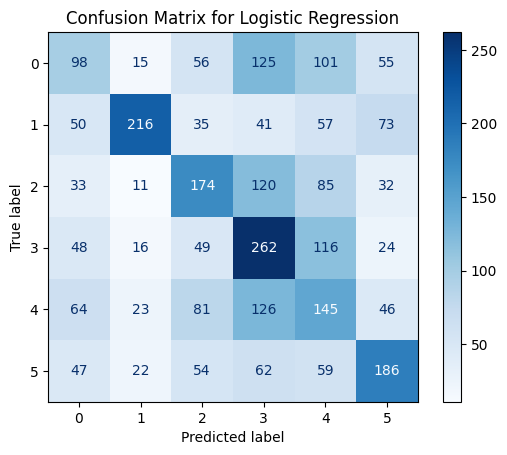

In [60]:
clf_cm = confusion_matrix(y_val_perc, clf_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=clf_cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

In [ ]:
# Prediction
# clf_pred = clf.predict(test_images_flat)

In [57]:
# print("\nClassification Report:\n", classification_report(test_labels, clf_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.19      0.22       437
           1       0.74      0.51      0.60       474
           2       0.38      0.42      0.40       553
           3       0.44      0.55      0.49       525
           4       0.26      0.34      0.29       510
           5       0.53      0.43      0.47       501

    accuracy                           0.41      3000
   macro avg       0.43      0.41      0.41      3000
weighted avg       0.43      0.41      0.42      3000



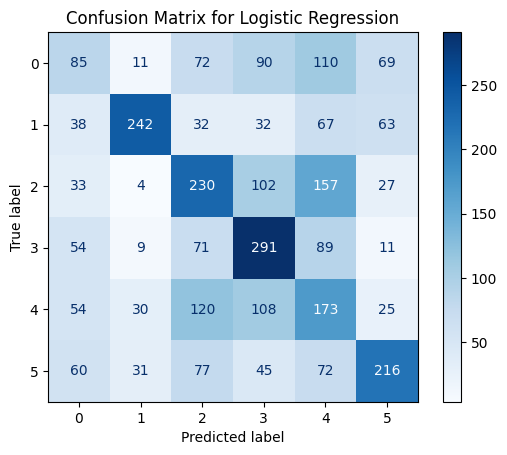

In [58]:
# clf_cm = confusion_matrix(test_labels, clf_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=clf_cm, display_labels=clf.classes_)
# disp.plot(cmap='Blues')
# plt.title("Confusion Matrix for Logistic Regression")
# plt.show()

##### HSV

In [48]:
# Training
# clf.fit(train_hsv_features, train_labels)

c:\Users\aolay\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=400, random_state=0)

In [ ]:
# Prediction
# clf_pred = clf.predict(test_hsv_features)

In [ ]:
# print("\nClassification Report:\n", classification_report(test_labels, clf_pred))

In [ ]:
# clf_cm = confusion_matrix(test_labels, clf_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=clf_cm, display_labels=clf.classes_)
# disp.plot(cmap='Blues')
# plt.title("Confusion Matrix for Logistic Regression")
# plt.show()

#### HOG

In [ ]:
# Training
# clf.fit(train_hog_features, train_labels)

In [ ]:
# Prediction
# clf_pred = clf.predict(test_hog_features)

In [ ]:
# print("\nClassification Report:\n", classification_report(test_labels, clf_pred))

In [ ]:
# clf_cm = confusion_matrix(test_labels, clf_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=clf_cm, display_labels=clf.classes_)
# disp.plot(cmap='Blues')
# plt.title("Confusion Matrix for Logistic Regression")
# plt.show()

### SVM

##### HSV - PCA

In [196]:
# HOG - PCA
# Create train/validation splits
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(
    train_hsv_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [197]:
# Define batch size
batch_size = 500
n_samples, n_features = X_train_ml.shape

# First pass: Compute mean and variance for StandardScaler
mean_sum = np.zeros(n_features, dtype=np.float32)
var_sum = np.zeros(n_features, dtype=np.float32)
n_total = 0

print("Computing mean and variance in batches...")
for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    
    # Update mean and variance sums
    mean_sum += np.sum(batch, axis=0)
    var_sum += np.sum(np.square(batch), axis=0)
    n_total += batch.shape[0]
    
    if i % 2000 == 0:
        print(f"Processed {i}/{n_samples} samples")

# Calculate final mean and variance
mean = mean_sum / n_total
variance = (var_sum / n_total) - np.square(mean)
scale = np.sqrt(variance)

Computing mean and variance in batches...
Processed 0/11227 samples
Processed 2000/11227 samples
Processed 4000/11227 samples
Processed 6000/11227 samples
Processed 8000/11227 samples
Processed 10000/11227 samples


In [198]:
# Initialize IPCA
print("Performing incremental PCA...")
n_components = 500
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    current_batch_size = end - i
    
    # Scale the batch manually
    batch_scaled = (batch - mean) / scale
    
    # Only try to fit if batch is large enough
    if current_batch_size >= n_components:
        ipca.partial_fit(batch_scaled)
        if i % 2000 == 0:
            print(f"Fitted PCA on {i}/{n_samples} samples")
    else:
        print(f"Skipping final incomplete batch of size {current_batch_size} (smaller than n_components={n_components})")

print("IPCA fitting complete!")

Performing incremental PCA...
Fitted PCA on 0/11227 samples
Fitted PCA on 2000/11227 samples
Fitted PCA on 4000/11227 samples
Fitted PCA on 6000/11227 samples
Fitted PCA on 8000/11227 samples
Fitted PCA on 10000/11227 samples
Skipping final incomplete batch of size 227 (smaller than n_components=500)
IPCA fitting complete!


In [199]:
# Third pass: Transform data in batches and train classifier
X_train_transformed = np.zeros((n_samples, n_components), dtype=np.float32)

print("Transforming data...")
for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    
    # Scale and transform batch
    batch_scaled = (batch - mean) / scale
    X_train_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_samples} samples")

print("Final reduced data shape:", X_train_transformed.shape)

Transforming data...
Transformed 0/11227 samples
Transformed 2000/11227 samples
Transformed 4000/11227 samples
Transformed 6000/11227 samples
Transformed 8000/11227 samples
Transformed 10000/11227 samples
Final reduced data shape: (11227, 500)


In [200]:
# Transform Validation Data
print("Transforming validation data...")
n_val_samples = X_val_ml.shape[0]
X_val_transformed = np.zeros((n_val_samples, n_components), dtype=np.float32)

for i in range(0, n_val_samples, batch_size):
    end = min(i + batch_size, n_val_samples)
    batch = X_val_ml[i:end].astype(np.float32)
    
    # Scale and transform batch using already computed mean/scale
    batch_scaled = (batch - mean) / scale
    X_val_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_val_samples} validation samples")

print("Validation data transformation complete!")
print("Validation data reduced shape:", X_val_transformed.shape)

Transforming validation data...
Transformed 0/2807 validation samples
Transformed 2000/2807 validation samples
Validation data transformation complete!
Validation data reduced shape: (2807, 500)


In [204]:
# Transform Test Data
print("Transforming test data...")
n_test_samples = test_images_flat.shape[0]
X_test_transformed = np.zeros((n_test_samples, n_components), dtype=np.float32)

for i in range(0, n_test_samples, batch_size):
    end = min(i + batch_size, n_test_samples)
    batch = test_images_flat[i:end].astype(np.float32)
    
    # Scale and transform batch using already computed mean/scale
    batch_scaled = (batch - mean) / scale
    X_test_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_test_samples} test samples")

print("Test data transformation complete!")
print("Test data reduced shape:", X_test_transformed.shape)

Transforming test data...
Transformed 0/3000 test samples
Transformed 2000/3000 test samples
Test data transformation complete!
Test data reduced shape: (3000, 500)


In [206]:
# Now we will standardize all 3 data sets

scaler = StandardScaler()

# Fit scaler on training data
X_train_transformed_scaled = scaler.fit_transform(X_train_transformed)

# Transform validation and test data using same scaler
X_val_transformed_scaled = scaler.transform(X_val_transformed)
X_test_transformed_scaled = scaler.transform(X_test_transformed)

In [ ]:
# total time 74.81 minutes

param_grid = {
    'C': [0.1, 1, 10],  # reduced C values
    'gamma': ['scale', 0.1, 1],  # reduced gamma values
    'kernel': ['rbf'],
    'class_weight': ['balanced']  # just try balanced weights
}

svc = SVC(random_state=42, probability=True)
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='balanced_accuracy'
)

# Add explicit print statements
print("Starting grid search...")

# Fit on training data
grid_search.fit(X_train_transformed_scaled, y_train_ml)

Starting grid search...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Total time taken: 74.81 minutes


In [215]:
# Print all scores
print("\nAll scores:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, std, params in zip(means, stds, params):
    print(f"Parameters: {params}")
    print(f"Mean score: {mean:.4f} (±{std:.4f})\n")

# Check class distribution
unique, counts = np.unique(train_labels, return_counts=True)
print("\nClass distribution:")
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} samples ({count/len(train_labels)*100:.2f}%)")


All scores:
Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Mean score: 0.4044 (±0.0093)

Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Mean score: 0.1667 (±0.0000)

Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
Mean score: 0.1667 (±0.0000)

Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Mean score: 0.5529 (±0.0081)

Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Mean score: 0.1708 (±0.0004)

Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
Mean score: 0.1665 (±0.0007)

Parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Mean score: 0.5475 (±0.0032)

Parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Mean score: 0.1693 (±0.0005)

Parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
Mean score: 

In [223]:
best_model = grid_search.best_estimator_

In [ ]:
# m  s
val_predictions = best_model.predict(X_val_transformed_scaled)
val_accuracy = accuracy_score(y_val_ml, val_predictions)
print(f"\nValidation accuracy: {val_accuracy:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val_ml, val_predictions))


Validation accuracy: 0.5949

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.48      0.50       450
           1       0.76      0.78      0.77       472
           2       0.57      0.67      0.62       455
           3       0.58      0.61      0.60       515
           4       0.50      0.42      0.46       485
           5       0.61      0.60      0.61       430

    accuracy                           0.59      2807
   macro avg       0.59      0.60      0.59      2807
weighted avg       0.59      0.59      0.59      2807


Test accuracy: 0.4760

Test Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.41      0.40       437
           1       0.55      0.74      0.63       474
           2       0.46      0.31      0.37       553
           3       0.47      0.68      0.56       525
           4       0.40      0.35      0.37       510
           5    

In [ ]:
# m  s
test_predictions = best_model.predict(X_test_transformed_scaled)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(test_labels, test_predictions))

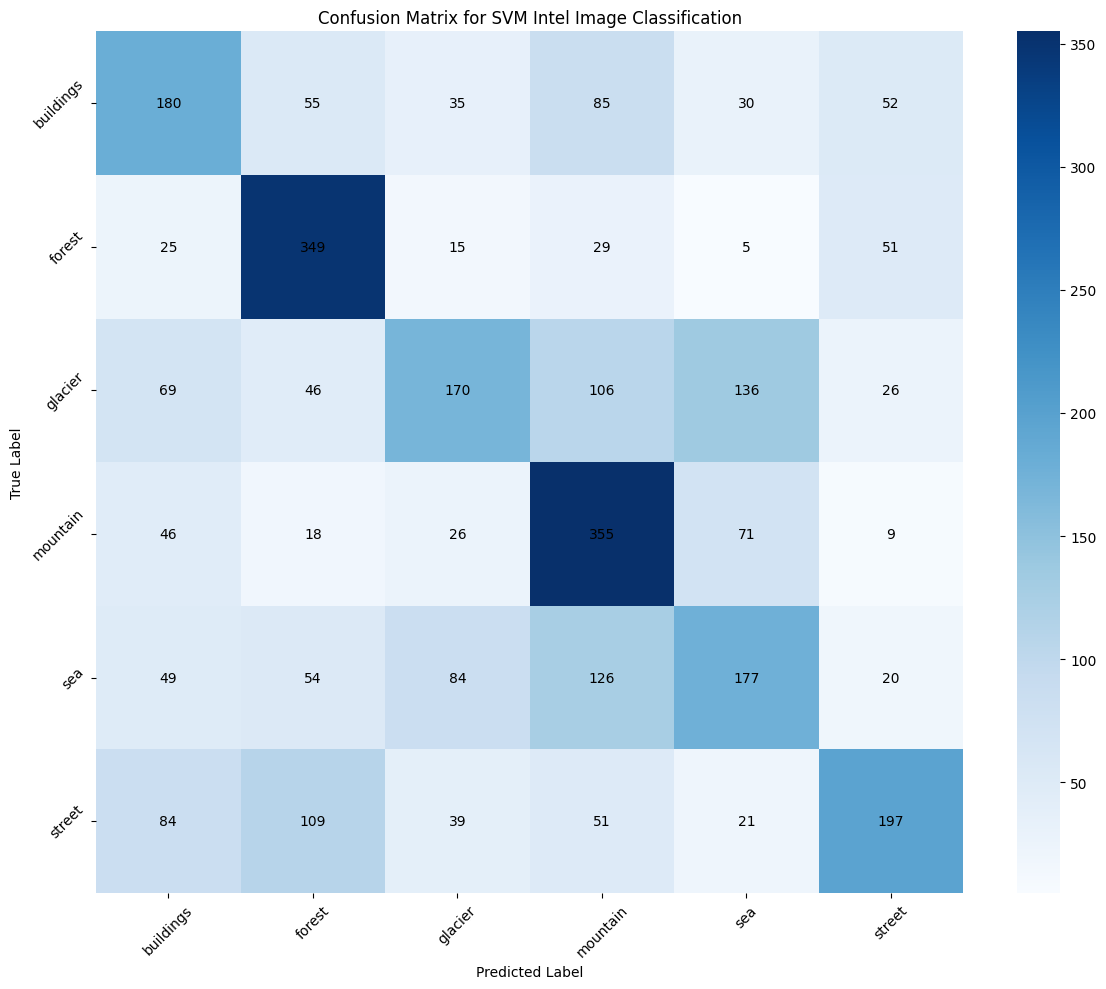

In [218]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(cm,          
            cmap='Blues',    
            xticklabels=class_names,
            yticklabels=class_names)  

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]),
                 ha='center', va='center',
                 color='black')

plt.title('Confusion Matrix for SVM Intel Image Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

#### HOG - PCA

In [69]:
# HOG - PCA
# Create train/validation splits
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(
    train_hog_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [70]:
# Define batch size
batch_size = 500
n_samples, n_features = X_train_ml.shape

# First pass: Compute mean and variance for StandardScaler
mean_sum = np.zeros(n_features, dtype=np.float32)
var_sum = np.zeros(n_features, dtype=np.float32)
n_total = 0

print("Computing mean and variance in batches...")
for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    
    # Update mean and variance sums
    mean_sum += np.sum(batch, axis=0)
    var_sum += np.sum(np.square(batch), axis=0)
    n_total += batch.shape[0]
    
    if i % 2000 == 0:
        print(f"Processed {i}/{n_samples} samples")

# Calculate final mean and variance
mean = mean_sum / n_total
variance = (var_sum / n_total) - np.square(mean)
scale = np.sqrt(variance)

Computing mean and variance in batches...
Processed 0/11227 samples
Processed 2000/11227 samples
Processed 4000/11227 samples
Processed 6000/11227 samples
Processed 8000/11227 samples
Processed 10000/11227 samples


In [71]:
# Initialize IPCA
print("Performing incremental PCA...")
n_components = 500
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    current_batch_size = end - i
    
    # Scale the batch manually
    batch_scaled = (batch - mean) / scale
    
    # Only try to fit if batch is large enough
    if current_batch_size >= n_components:
        ipca.partial_fit(batch_scaled)
        if i % 2000 == 0:
            print(f"Fitted PCA on {i}/{n_samples} samples")
    else:
        print(f"Skipping final incomplete batch of size {current_batch_size} (smaller than n_components={n_components})")

print("IPCA fitting complete!")

Performing incremental PCA...
Fitted PCA on 0/11227 samples
Fitted PCA on 2000/11227 samples
Fitted PCA on 4000/11227 samples
Fitted PCA on 6000/11227 samples
Fitted PCA on 8000/11227 samples
Fitted PCA on 10000/11227 samples
Skipping final incomplete batch of size 227 (smaller than n_components=500)
IPCA fitting complete!


In [72]:
# Third pass: Transform data in batches and train classifier
X_train_transformed = np.zeros((n_samples, n_components), dtype=np.float32)

print("Transforming data...")
for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    
    # Scale and transform batch
    batch_scaled = (batch - mean) / scale
    X_train_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_samples} samples")

print("Final reduced data shape:", X_train_transformed.shape)

Transforming data...
Transformed 0/11227 samples
Transformed 2000/11227 samples
Transformed 4000/11227 samples
Transformed 6000/11227 samples
Transformed 8000/11227 samples
Transformed 10000/11227 samples
Final reduced data shape: (11227, 500)


In [73]:
# Transform Validation Data
print("Transforming validation data...")
n_val_samples = X_val_ml.shape[0]
X_val_transformed = np.zeros((n_val_samples, n_components), dtype=np.float32)

for i in range(0, n_val_samples, batch_size):
    end = min(i + batch_size, n_val_samples)
    batch = X_val_ml[i:end].astype(np.float32)
    
    # Scale and transform batch using already computed mean/scale
    batch_scaled = (batch - mean) / scale
    X_val_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_val_samples} validation samples")

print("Validation data transformation complete!")
print("Validation data reduced shape:", X_val_transformed.shape)

Transforming validation data...
Transformed 0/2807 validation samples
Transformed 2000/2807 validation samples
Validation data transformation complete!
Validation data reduced shape: (2807, 500)


In [74]:
# Transform Test Data
print("Transforming test data...")
n_test_samples = test_images_flat.shape[0]
X_test_transformed = np.zeros((n_test_samples, n_components), dtype=np.float32)

for i in range(0, n_test_samples, batch_size):
    end = min(i + batch_size, n_test_samples)
    batch = test_images_flat[i:end].astype(np.float32)
    
    # Scale and transform batch using already computed mean/scale
    batch_scaled = (batch - mean) / scale
    X_test_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_test_samples} test samples")

print("Test data transformation complete!")
print("Test data reduced shape:", X_test_transformed.shape)

Transforming test data...
Transformed 0/3000 test samples
Transformed 2000/3000 test samples
Test data transformation complete!
Test data reduced shape: (3000, 500)


In [75]:
# Now we will standardize all 3 data sets

scaler = StandardScaler()

# Fit scaler on training data
X_train_transformed_scaled = scaler.fit_transform(X_train_transformed)

# Transform validation and test data using same scaler
X_val_transformed_scaled = scaler.transform(X_val_transformed)
X_test_transformed_scaled = scaler.transform(X_test_transformed)

In [76]:
# total time 74.81 minutes

param_grid = {
    'C': [0.1, 1, 10],  # reduced C values
    'gamma': ['scale', 0.1, 1],  # reduced gamma values
    'kernel': ['rbf'],
    'class_weight': ['balanced']  # just try balanced weights
}

svc = SVC(random_state=42, probability=True)
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='balanced_accuracy'
)

# Add explicit print statements
print("Starting grid search...")

# Fit on training data
grid_search.fit(X_train_transformed_scaled, y_train_ml)

Starting grid search...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'class_weight': ['balanced'],
                         'gamma': ['scale', 0.1, 1], 'kernel': ['rbf']},
             scoring='balanced_accuracy', verbose=2)

In [77]:
# Print all scores
print("\nAll scores:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, std, params in zip(means, stds, params):
    print(f"Parameters: {params}")
    print(f"Mean score: {mean:.4f} (±{std:.4f})\n")

# Check class distribution
unique, counts = np.unique(train_labels, return_counts=True)
print("\nClass distribution:")
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} samples ({count/len(train_labels)*100:.2f}%)")


All scores:
Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Mean score: 0.4077 (±0.0113)

Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Mean score: 0.1667 (±0.0000)

Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
Mean score: 0.1667 (±0.0000)

Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Mean score: 0.5695 (±0.0050)

Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Mean score: 0.1737 (±0.0002)

Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
Mean score: 0.1674 (±0.0003)

Parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Mean score: 0.5663 (±0.0045)

Parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Mean score: 0.1696 (±0.0006)

Parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
Mean score: 

In [78]:
best_model = grid_search.best_estimator_

In [ ]:
# 22 s
val_predictions = best_model.predict(X_val_transformed_scaled)
val_accuracy = accuracy_score(y_val_ml, val_predictions)
print(f"\nValidation accuracy: {val_accuracy:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val_ml, val_predictions))


Validation accuracy: 0.6063

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.51      0.52       450
           1       0.82      0.76      0.79       472
           2       0.57      0.62      0.59       455
           3       0.60      0.64      0.62       515
           4       0.50      0.47      0.49       485
           5       0.62      0.63      0.63       430

    accuracy                           0.61      2807
   macro avg       0.61      0.61      0.61      2807
weighted avg       0.61      0.61      0.61      2807



In [ ]:
# 24.8 s
test_predictions = best_model.predict(X_test_transformed_scaled)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(test_labels, test_predictions))


Test accuracy: 0.1457

Test Classification Report:
              precision    recall  f1-score   support

           0       0.15      1.00      0.25       437
           1       0.00      0.00      0.00       474
           2       0.00      0.00      0.00       553
           3       0.00      0.00      0.00       525
           4       0.00      0.00      0.00       510
           5       0.00      0.00      0.00       501

    accuracy                           0.15      3000
   macro avg       0.02      0.17      0.04      3000
weighted avg       0.02      0.15      0.04      3000



c:\Users\aolay\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aolay\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aolay\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


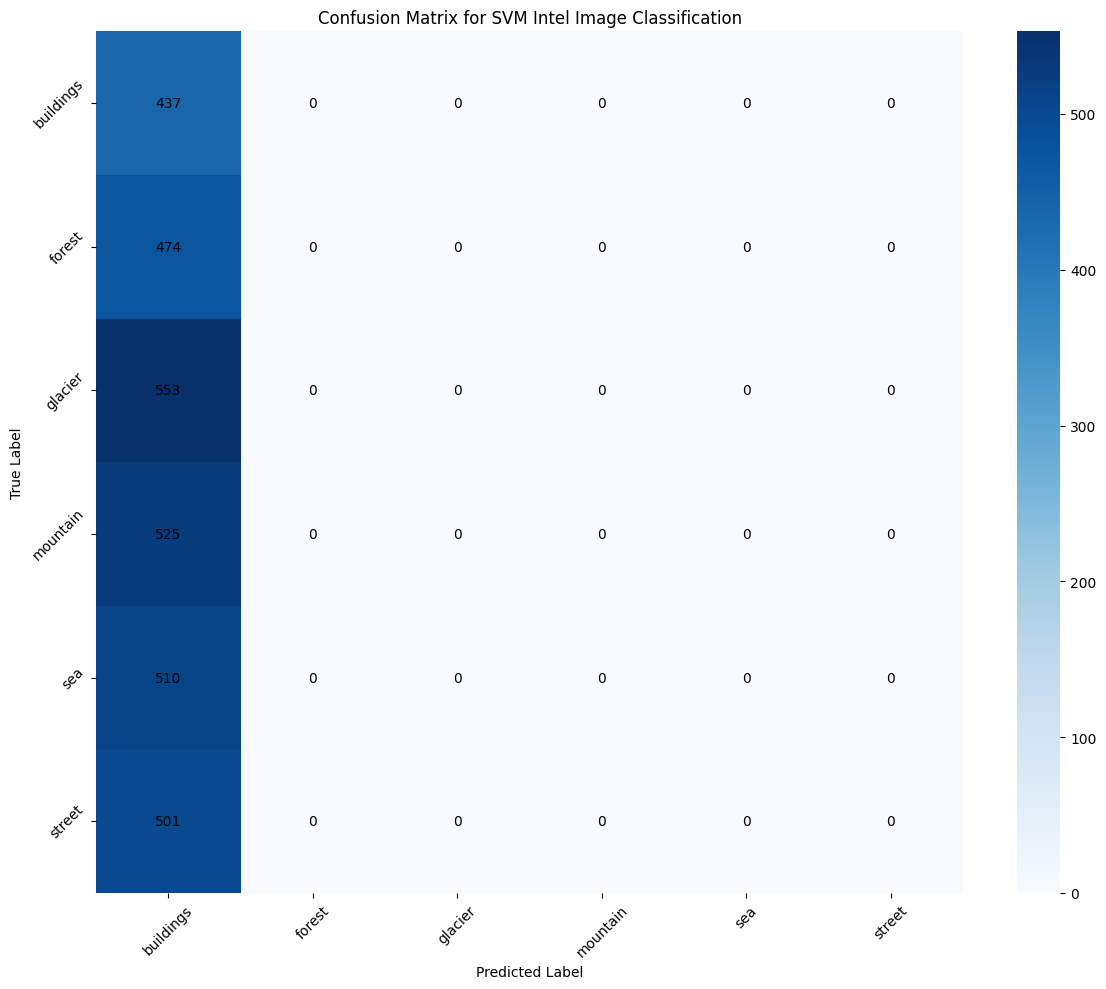

In [81]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(cm,          
            cmap='Blues',    
            xticklabels=class_names,
            yticklabels=class_names)  

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]),
                 ha='center', va='center',
                 color='black')

plt.title('Confusion Matrix for SVM Intel Image Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()